#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `co-occurrence`

#### Group:
- `Adriana Pinto - 20221921`
- `David Duarte - 20221899`
- `Maria Teresa Silva - 20221821`
- `Marta Alves - 20221890`
- `Miguel Nascimento - 20221876`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Imports](#imports)
- [2. Co-occurrence](#co-occurence)
    - [2.1 Specific Data Preparation](#specific-data-preparation)
    - [2.2 Model Implementation](#model-implementation)
    - [2.3 Network Graph](#network-graph)
    - [2.4 Clustering](#clustering)


<font color='#BFD72F' size=5>1. Imports </font>   
[Back to TOC](#toc)


In [3]:
import os  
import re  
import pickle  

import numpy as np  
import pandas as pd  

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px  

from nltk.tokenize import PunktSentenceTokenizer  
from utils.gibberish_detector import classify_gibberish  
from utils.preproc_utils import main_pipeline 
import spacy  

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.cluster import KMeans  

from sklearn.metrics import silhouette_score, calinski_harabasz_score

from transformers import pipeline  
from transformers import AutoTokenizer, AutoModelForSequenceClassification  

import torch 

import networkx as nx  

from tqdm import tqdm 

from collections import defaultdict, Counter  

from sklearn.decomposition import TruncatedSVD

<font color='#BFD72F' size=5>2. Co-occurrence </font>   
[Back to TOC](#toc)


<font color='#BFD72F' size=5>2.1 Specific data preparation </font> <a class="anchor" id="P21"></a>


#### Load datasets

In [4]:
reviews = pd.read_pickle('data/reviews_initial_preproc.pkl')

In [5]:
restaurants = pd.read_pickle('data/restaurants_initial_preproc.pkl')

#### Pre Process reviews dataset

Two new columns have been created: 'rev_proc_token' and 'rev_proc'. The key distinction between these columns is that one is tokenized ('rev_proc_token') while the other is not ('rev_proc'). This differentiation is essential, as both versions will be used to construct co-occurrence matrices in subsequent steps.

In [7]:
reviews['rev_proc_token'] = reviews['Review'].apply(lambda review: main_pipeline(review, 
                  no_stopwords = True,
                  convert_diacritics = True, 
                  lowercase = True, 
                  lemmatized = True,
                  list_pos = ["n","v","a","r","s"],
                  stemmed = False, 
                  pos_tags_list = "no_pos",
                  tokenized_output = True,
                  word_correction=False,
                  no_emojis = True,
                  no_hashtags = True))

In [8]:
reviews["is_giberish"] =\
      reviews["rev_proc_token"].apply(lambda review : classify_gibberish(str(review)))
reviews= reviews[reviews['is_giberish']<90]

In [9]:
reviews['rev_proc'] = reviews['Review'].apply(lambda review: main_pipeline(review, 
                  no_stopwords = True,
                  convert_diacritics = True, 
                  lowercase = True, 
                  lemmatized = True,
                  list_pos = ["n","v","a","r","s"],
                  stemmed = False, 
                  pos_tags_list = "no_pos",
                  tokenized_output = False,
                  word_correction=False,
                  no_emojis = True,
                  no_hashtags = True))

reviews["is_giberish1"] =\
      reviews["rev_proc"].apply(lambda review : classify_gibberish(str(review)))
reviews= reviews[reviews['is_giberish1']<90]

<font color='#BFD72F' size=5> 2.2 Model implementation </font> <a class="anchor" id="P21"></a>
[Back to TOC](#toc)

#### First co-occurrence plot

In [228]:
def cooccurrence_matrix_sentence_generator(preproc_sentences):

    co_occurrences = defaultdict(Counter)

    # Compute co-occurrences
    for sentence in tqdm(preproc_sentences):
        for token_1 in sentence:
            for token_2 in sentence:
                if token_1 != token_2:
                    co_occurrences[token_1][token_2] += 1

    #ensure that words are unique
    unique_words = list(set([word for sentence in preproc_sentences for word in sentence]))

    # Initialize the co-occurrence matrix
    co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the co-occurrence matrix
    word_index = {word: idx for idx, word in enumerate(unique_words)}
    for word, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[word_index[word]][word_index[neighbor]] = count

    # Create a DataFrame for better readability
    co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)

    # Return the co-occurrence matrix
    return co_matrix_df

In [229]:
reviews_co_occurrence = cooccurrence_matrix_sentence_generator(reviews["rev_proc_token"].tolist())

100%|██████████| 9804/9804 [00:13<00:00, 723.76it/s] 


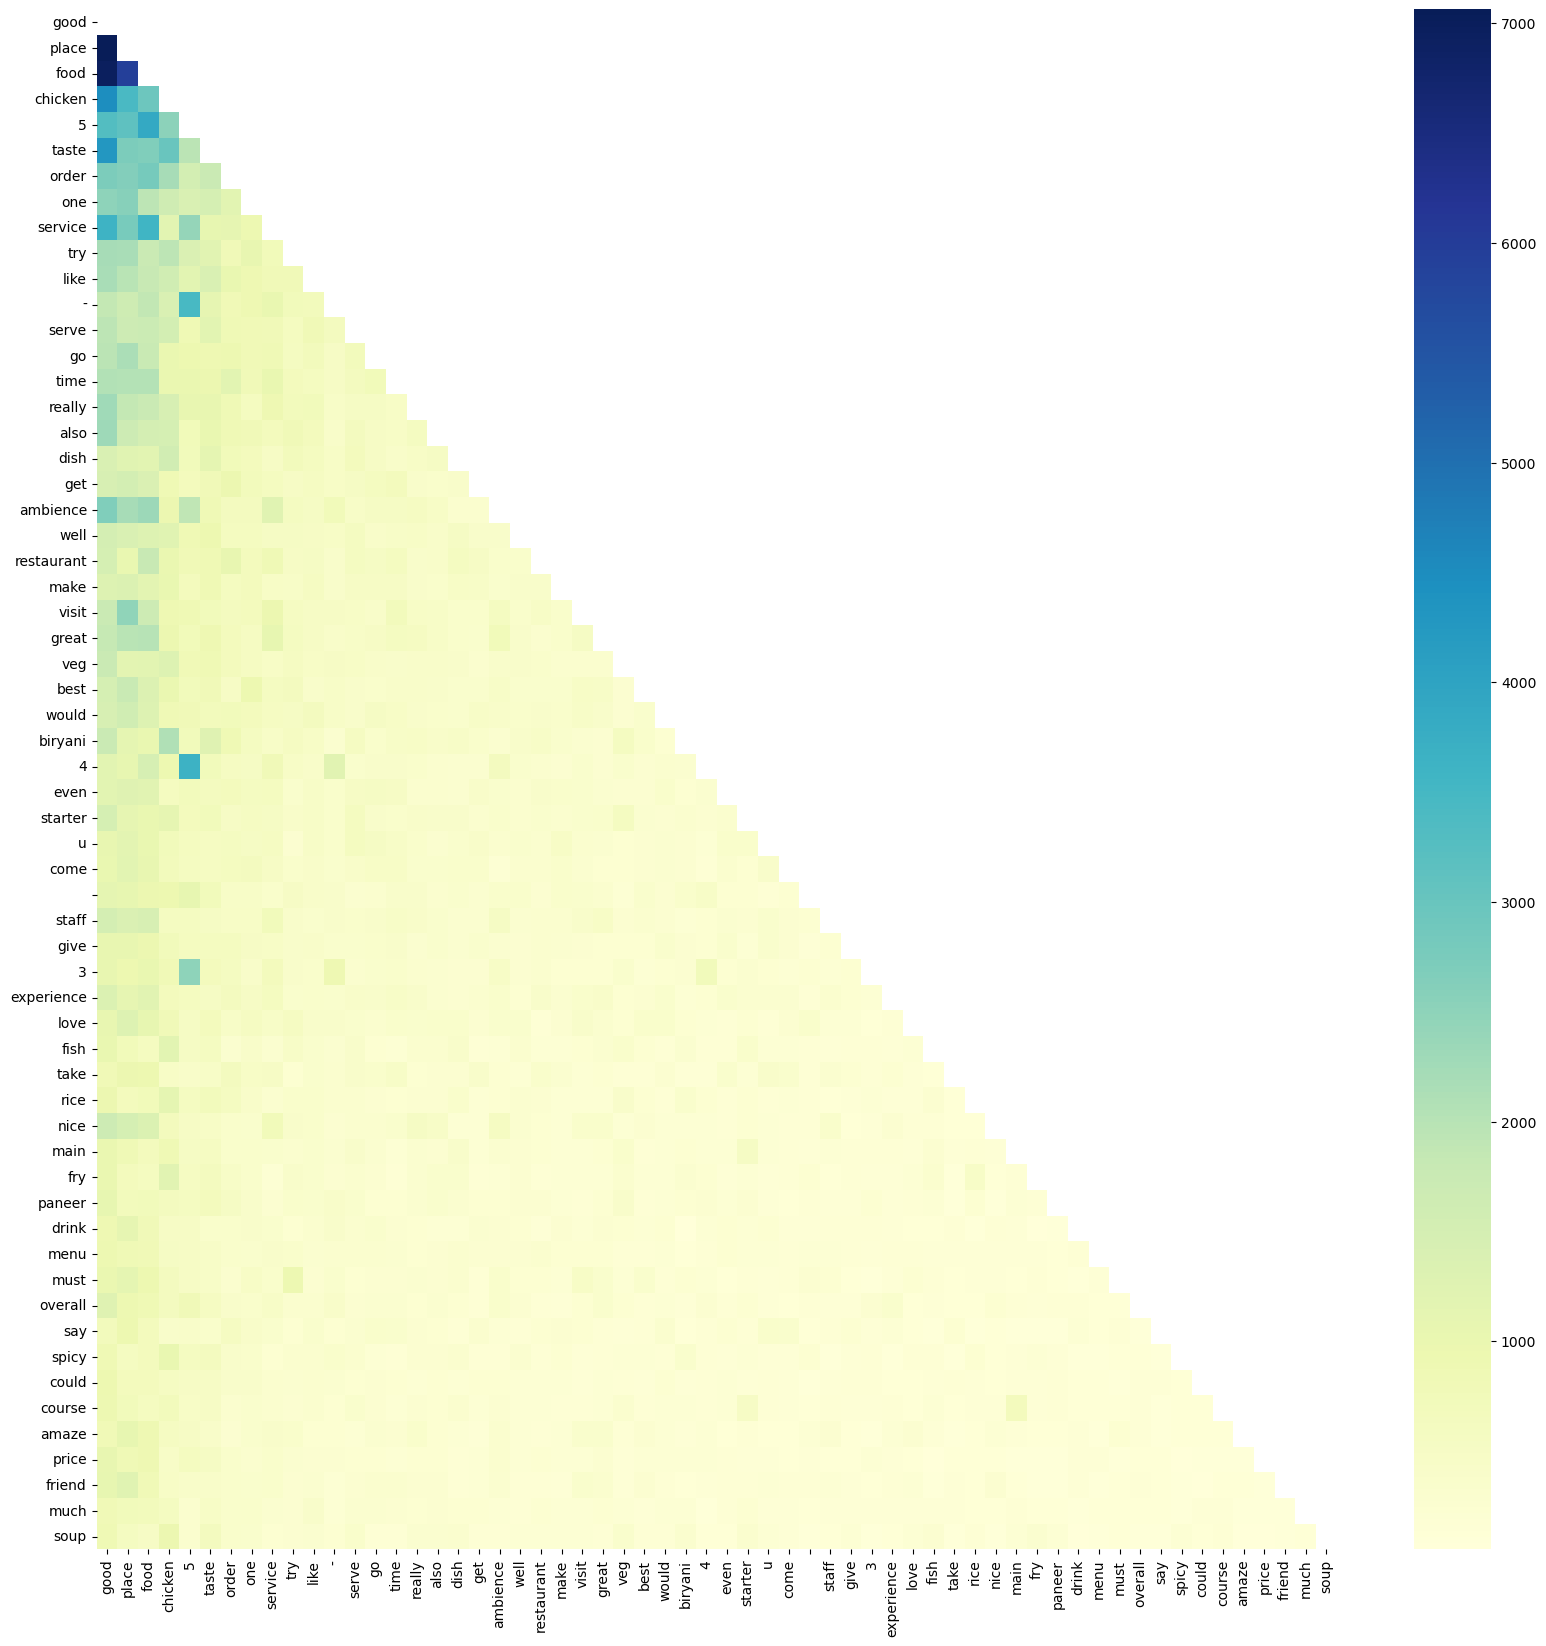

In [230]:
# Create a mask for the upper triangle, but leave the diagonal elements as True
mask = np.triu(np.ones_like(reviews_co_occurrence.iloc[:60, :60], dtype=bool))

# Create heatmap from the co-occurrence matrix using 
plt.figure(figsize=(20,20))
sns.heatmap(reviews_co_occurrence.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

In this co-occurrence matrix it is not possible to identify any dishes, we can only identify ingredients and words that are unrelated to food.

#### Co-occurrence with ngrams

After plotting the initial co-occurrence matrix, it was concluded that there were not enough food or dish related terms to effectively assess how often they appeared together in a review. As a result, it was decided to experiment with n-grams, as they could better capture dish names, which are often composed of two or more words.

In [233]:
def generate_cooccurrence_matrix_ngrams(dataframe, text_column, chunk_size=1000, ngram_range=(2, 2), top_n=100):

    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    co_matrix = None
    vocabulary = []

    num_rows = len(dataframe)

    # Process the data in chunks
    for start in range(0, num_rows, chunk_size):
        end = min(start + chunk_size, num_rows)
        
        chunk_data = dataframe[text_column][start:end]
        X_chunk = vectorizer.fit_transform(chunk_data) # Tokenize and get the n-gram counts
        
        current_vocabulary = vectorizer.get_feature_names_out()
        
        # Ensuring global vocabulary is consistent
        if len(vocabulary) == 0:
            # Initialize the global vocabulary and co-occurrence matrix with the first chunk
            vocabulary = current_vocabulary
            co_matrix = X_chunk.T @ X_chunk
        else:
            # Re-align vocabulary
            common_vocabulary = np.intersect1d(vocabulary, current_vocabulary)
            
            # Get indices of common vocabulary
            global_indices = np.array([np.where(vocabulary == word)[0][0] for word in common_vocabulary])
            current_indices = np.array([np.where(current_vocabulary == word)[0][0] for word in common_vocabulary])
            
            # Update the global co-occurrence matrix
            co_matrix_subset = co_matrix[global_indices, :][:, global_indices]
            current_co_matrix = X_chunk[:, current_indices].T @ X_chunk[:, current_indices]
            co_matrix[global_indices, :][:, global_indices] += current_co_matrix
        
    
    # Convert the final co-occurrence matrix to a DataFrame
    co_matrix_df = pd.DataFrame(co_matrix.toarray(), index=vocabulary, columns=vocabulary)
    
    # Select the top `top_n` most frequent n-grams
    co_matrix_df = co_matrix_df.loc[co_matrix_df.sum(axis=1).sort_values(ascending=False).head(top_n).index, 
                                     co_matrix_df.sum(axis=0).sort_values(ascending=False).head(top_n).index]
    
    return co_matrix_df

In [234]:
co_matrix_df = generate_cooccurrence_matrix_ngrams(reviews, text_column='rev_proc', chunk_size=1000, ngram_range=(2, 2), top_n=100)

C:\Users\adria\anaconda3\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



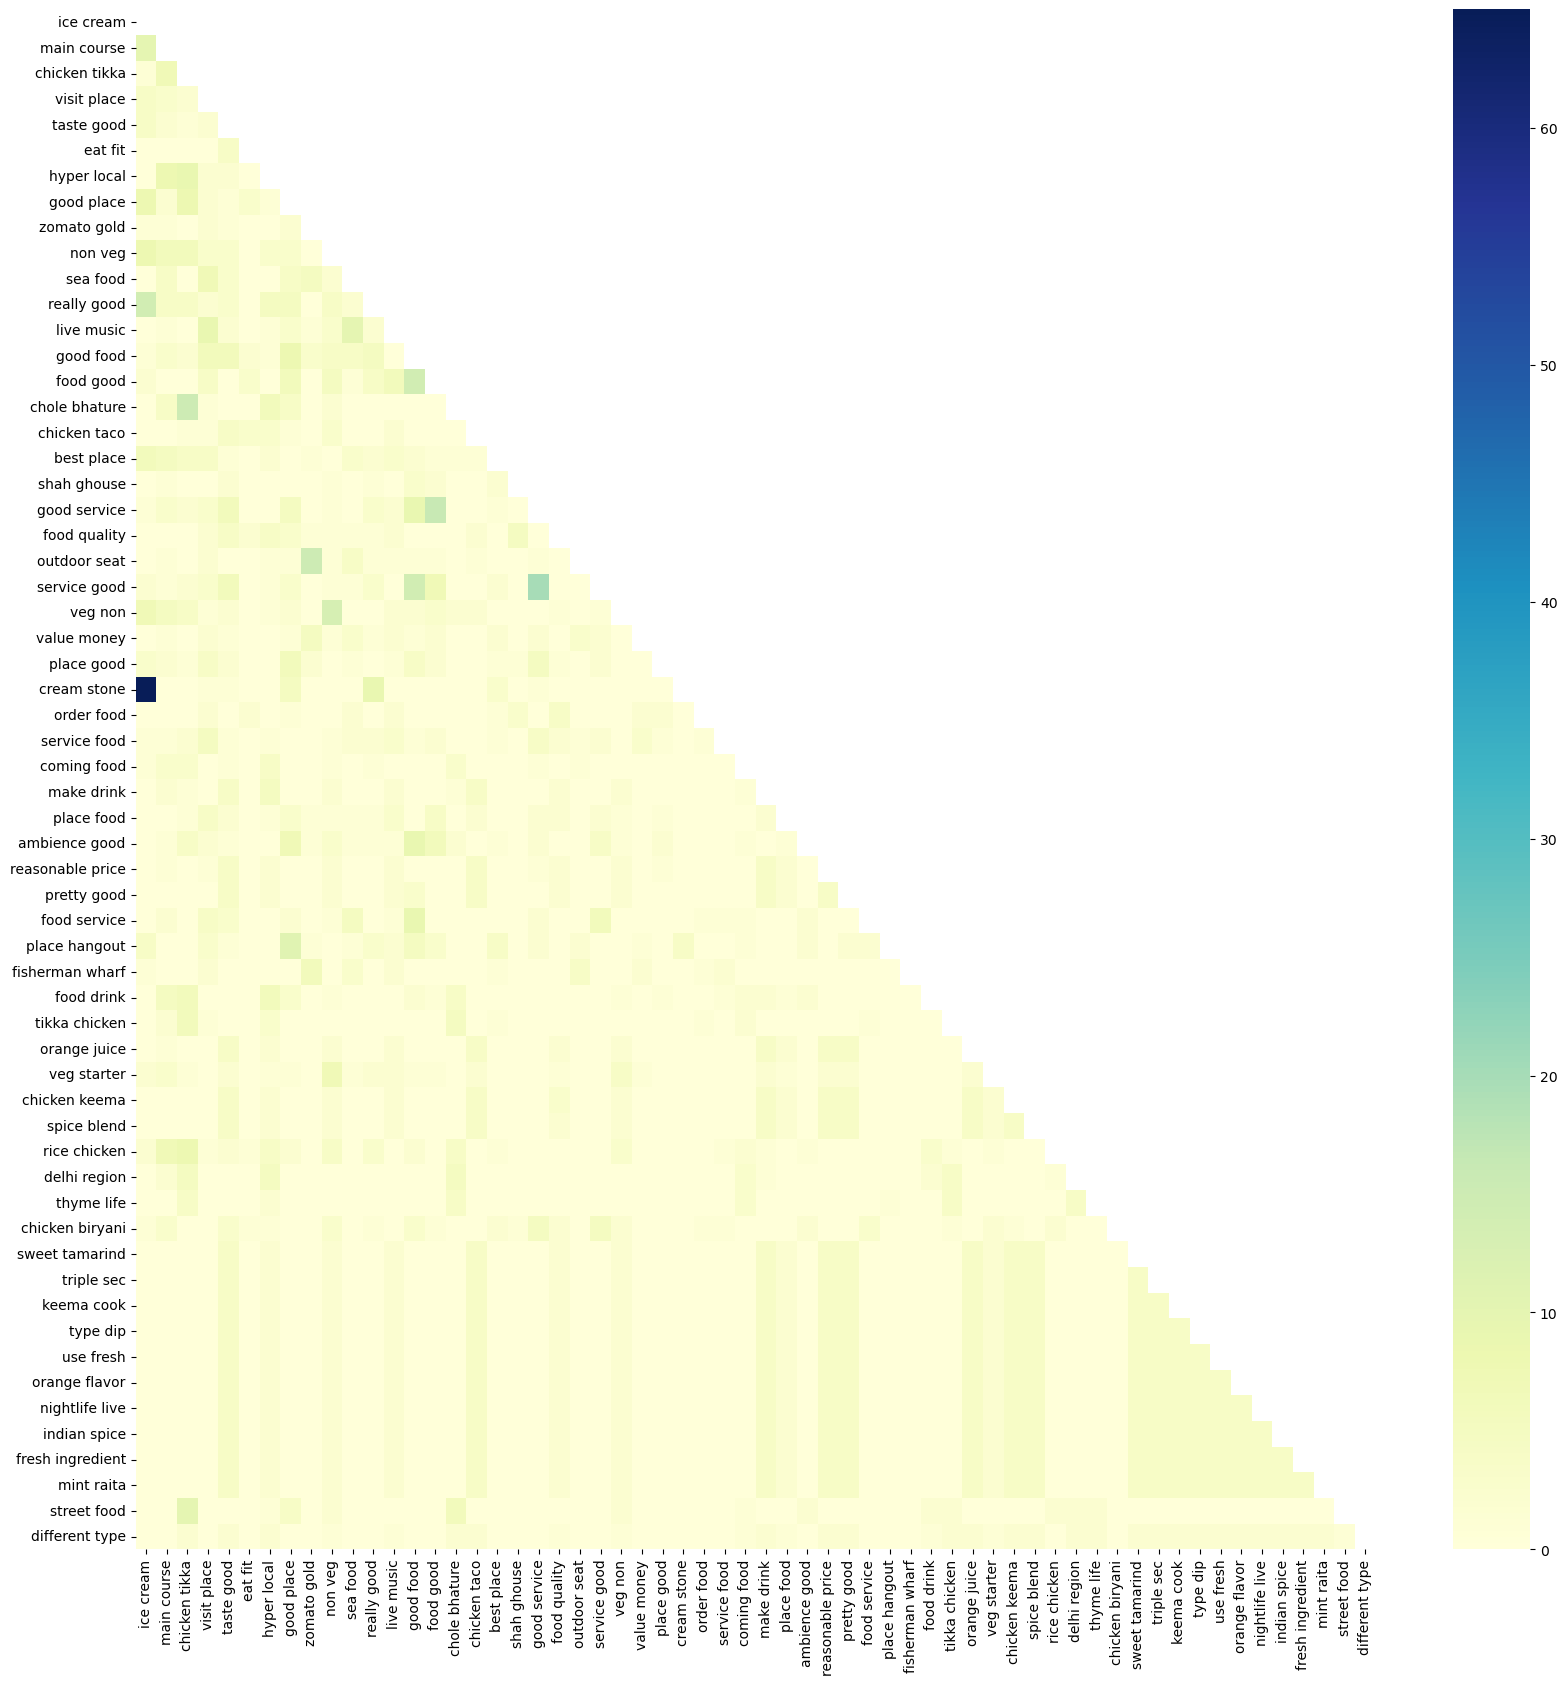

In [235]:
mask = np.triu(np.ones_like(co_matrix_df.iloc[:60, :60], dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(co_matrix_df.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

In this co-occurrence matrix, it is now possible to identify dishes such as"chicken biryani" and "tikka chicken". However, there are still combinations like "ambience good" and "place food" that are not useful.

#### Co-occurrence with ngrams - Specific word removal

Using bi-grams helped identify the names of some dishes. However, since the words 'food,' 'place,' and 'good' appeared in numerous combinations and were not informative, it was decided to remove them.

In [238]:
words_to_remove = {'food', 'good', 'place'}

def remove_specific_words(review):
    review_words = review.split()  # Split the review into words
    filtered_review = [word for word in review_words if word not in words_to_remove]  # Remove specific words
    return " ".join(filtered_review)  # Return the filtered review as a string

In [239]:
reviews['rev_proc'] = reviews['rev_proc'].apply(remove_specific_words)

In [240]:
print(reviews[['rev_proc']].head())

                                            rev_proc
0  ambience quite saturday lunch cost effective s...
1  ambience pleasant even service prompt experien...
2  must try great great ambience thnx service pra...
3  soumen da arun great guy behavior sincerety co...
4  order kodi drumstick basket mutton biryani tha...


In [241]:
cooccurrence_matrix = generate_cooccurrence_matrix_ngrams(reviews, text_column='rev_proc', chunk_size=1000, ngram_range=(2, 2), top_n=100)

C:\Users\adria\anaconda3\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



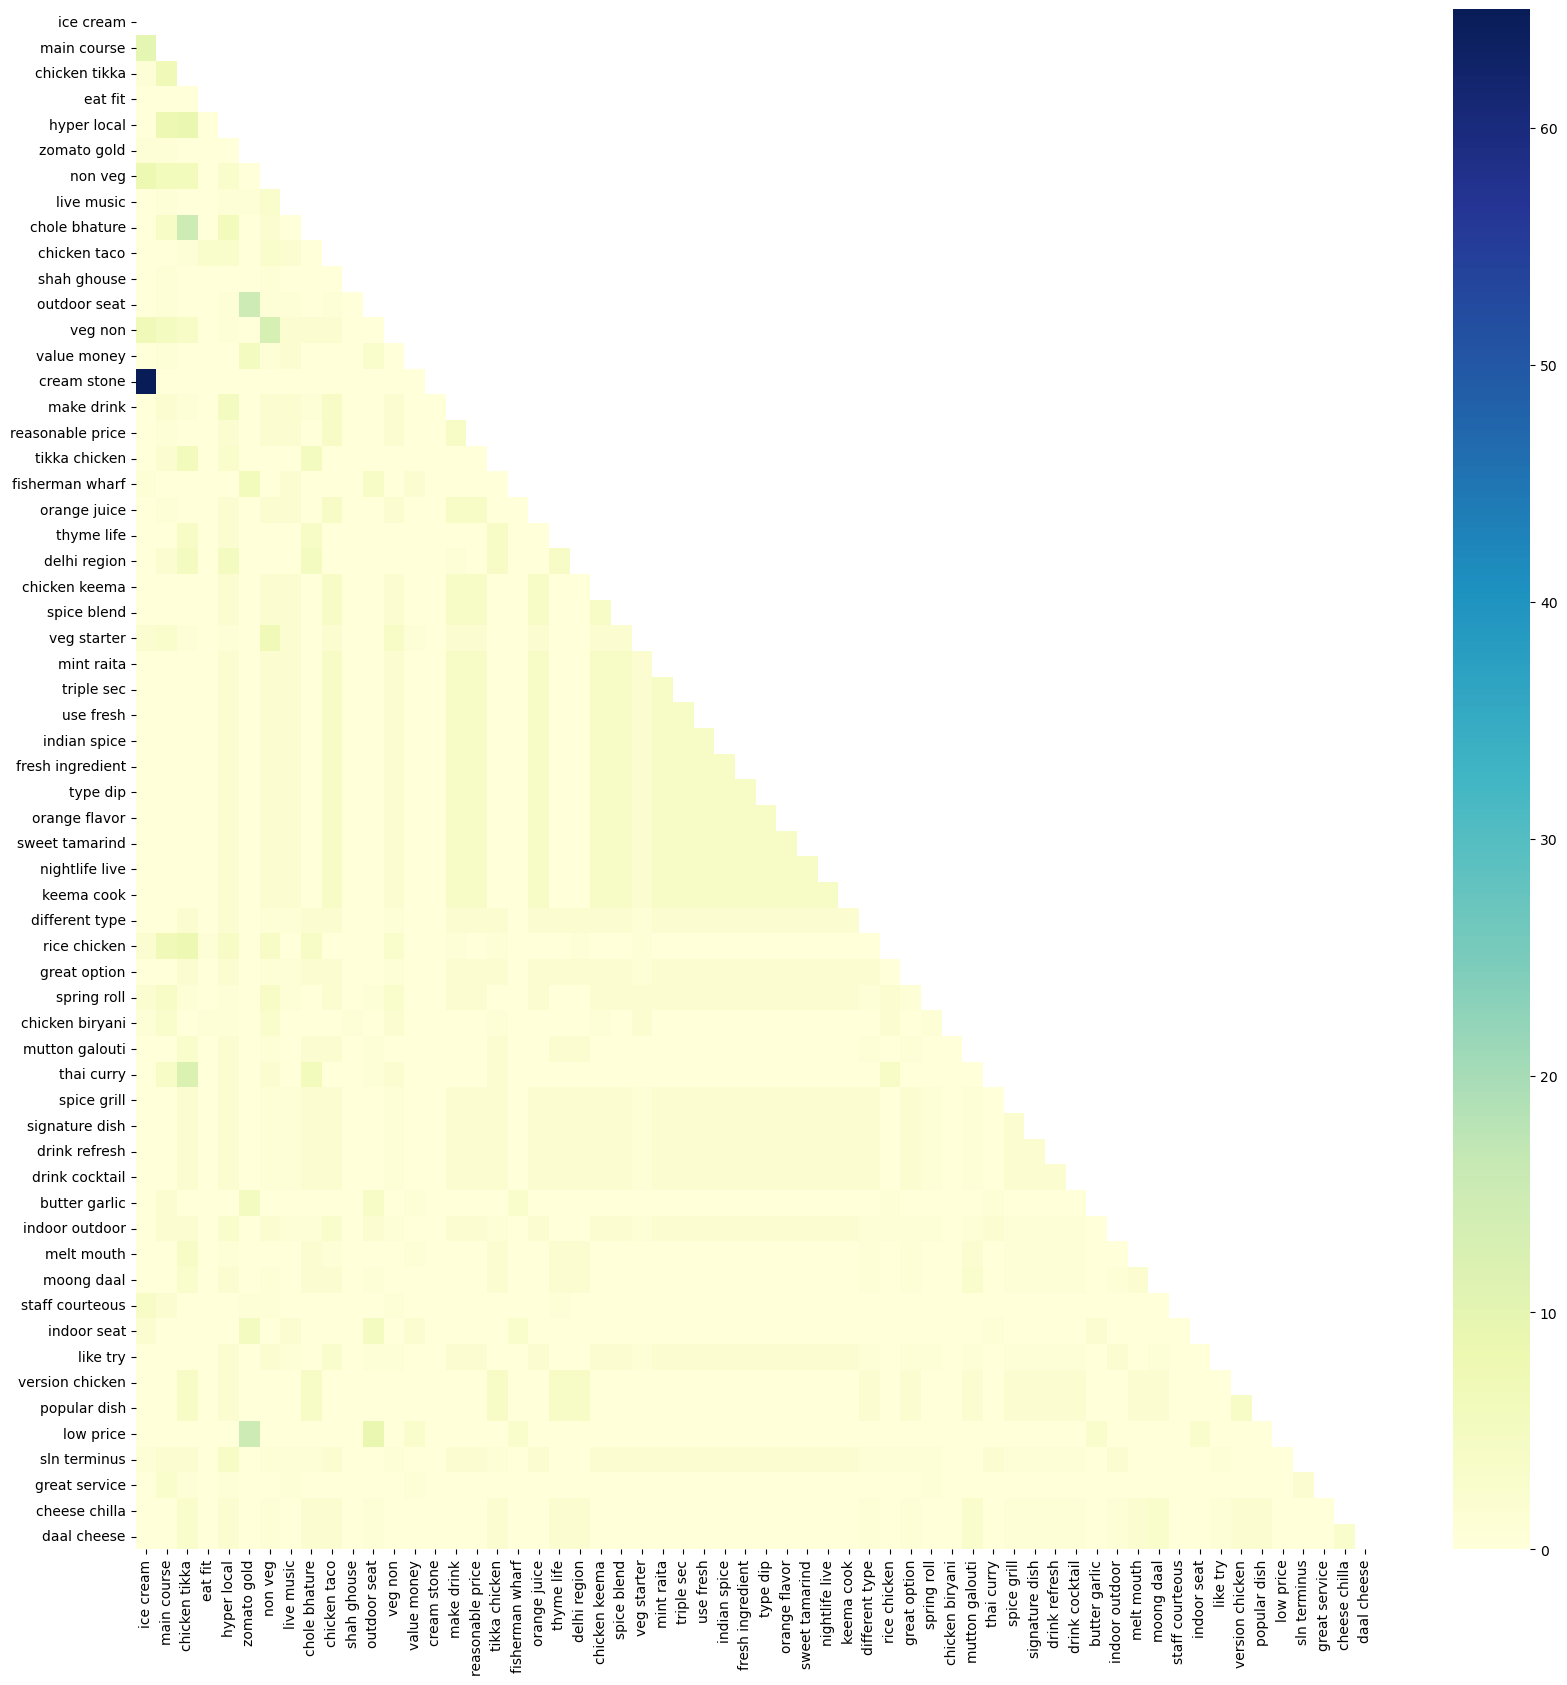

In [242]:
mask = np.triu(np.ones_like(co_matrix_df.iloc[:60, :60], dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(cooccurrence_matrix.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

Now, we have new dishes but they still do not appear that many times together.

#### Named Entity Recognition

After removing those words, our co-occurrence matrix contained more dish-related terms. However, despite this improvement, it was still insufficient. Therefore, we will use Named Entity Recognition to further enhance the results.

In [245]:
nlp = spacy.load("en_core_web_sm")

# irrelevant entity types to exclude
irrelevant_entity_types = ["PERSON", "DATE", "TIME", "GPE", "LOC", "MONEY", "PERCENT", "CARDINAL", "ORDINAL", "FAC"]

sent_tokenizer = PunktSentenceTokenizer()
reviews['tokenized_sentences'] = reviews['rev_proc'].apply(lambda review: sent_tokenizer.tokenize(str(review)))

# Flatten the tokenized sentences into a single DataFrame
sentences_list = []
for index, sentences in enumerate(reviews['tokenized_sentences']):
    for sentence in sentences:
        sentences_list.append({"review_id": index, "sentence": sentence})

sentences_df = pd.DataFrame(sentences_list)

# Filter sentences with less than 5 tokens
sentences_df["len_preproc_sentence"] = sentences_df["sentence"].apply(lambda sentence: len(sentence))
sentences_df = sentences_df.loc[sentences_df["len_preproc_sentence"] >= 5]

sentences_df = sentences_df.drop(columns="len_preproc_sentence")

# Extract Named Entities from the sentences and filter out irrelevant ones
def filter_relevant_entities(sentence):
    doc = nlp(sentence)
    relevant_entities = [ent.text for ent in doc.ents if ent.label_ not in irrelevant_entity_types]
    return relevant_entities

sentences_df["filtered_entities_list"] = sentences_df["sentence"].apply(filter_relevant_entities)

# Convert the list of entities into a single string separated by commas
sentences_df["filtered_entities_string"] = sentences_df["filtered_entities_list"].apply(lambda entities: ", ".join(entities))
sentences_df

review_id                                           sentence  \
0             0  ambience quite saturday lunch cost effective s...   
1             1  ambience pleasant even service prompt experien...   
2             2  must try great great ambience thnx service pra...   
3             3  soumen da arun great guy behavior sincerety co...   
4             4  order kodi drumstick basket mutton biryani tha...   
...         ...                                                ...   
9439       9799  madhumathi mahajan well start nice courteous s...   
9440       9800  never disappoint u courteous staff serene ambi...   
9441       9801  bad rat mainly chicken bone find veg acceptabl...   
9442       9802  personally love prefer chinese couple time hus...   
9443       9803  checked try delicious chinese see non-veg lunc...   

                       filtered_entities_list  \
0                                          []   
1                                          []   
2                                          []   
3                                          []   
4                                          []   
...                                       ...   
9439                                  [wifey]   
9440                        [garlic, chinese]   
9441  [chinese, chinese, fond potato, indian]   
9442                                [chinese]   
9443                                [chinese]   

                   filtered_entities_string  
0                                            
1                                            
2                                            
3                                            
4                                            
...                                     ...  
9439                                  wifey  
9440                        garlic, chinese  
9441  chinese, chinese, fond potato, indian  
9442                                chinese  
9443                                chinese  

[9273 rows x 4 columns]

In [246]:
cooccurrence_matrix = generate_cooccurrence_matrix_ngrams(sentences_df, text_column='filtered_entities_string', chunk_size=1000, ngram_range=(2, 2), top_n=100)

C:\Users\adria\anaconda3\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



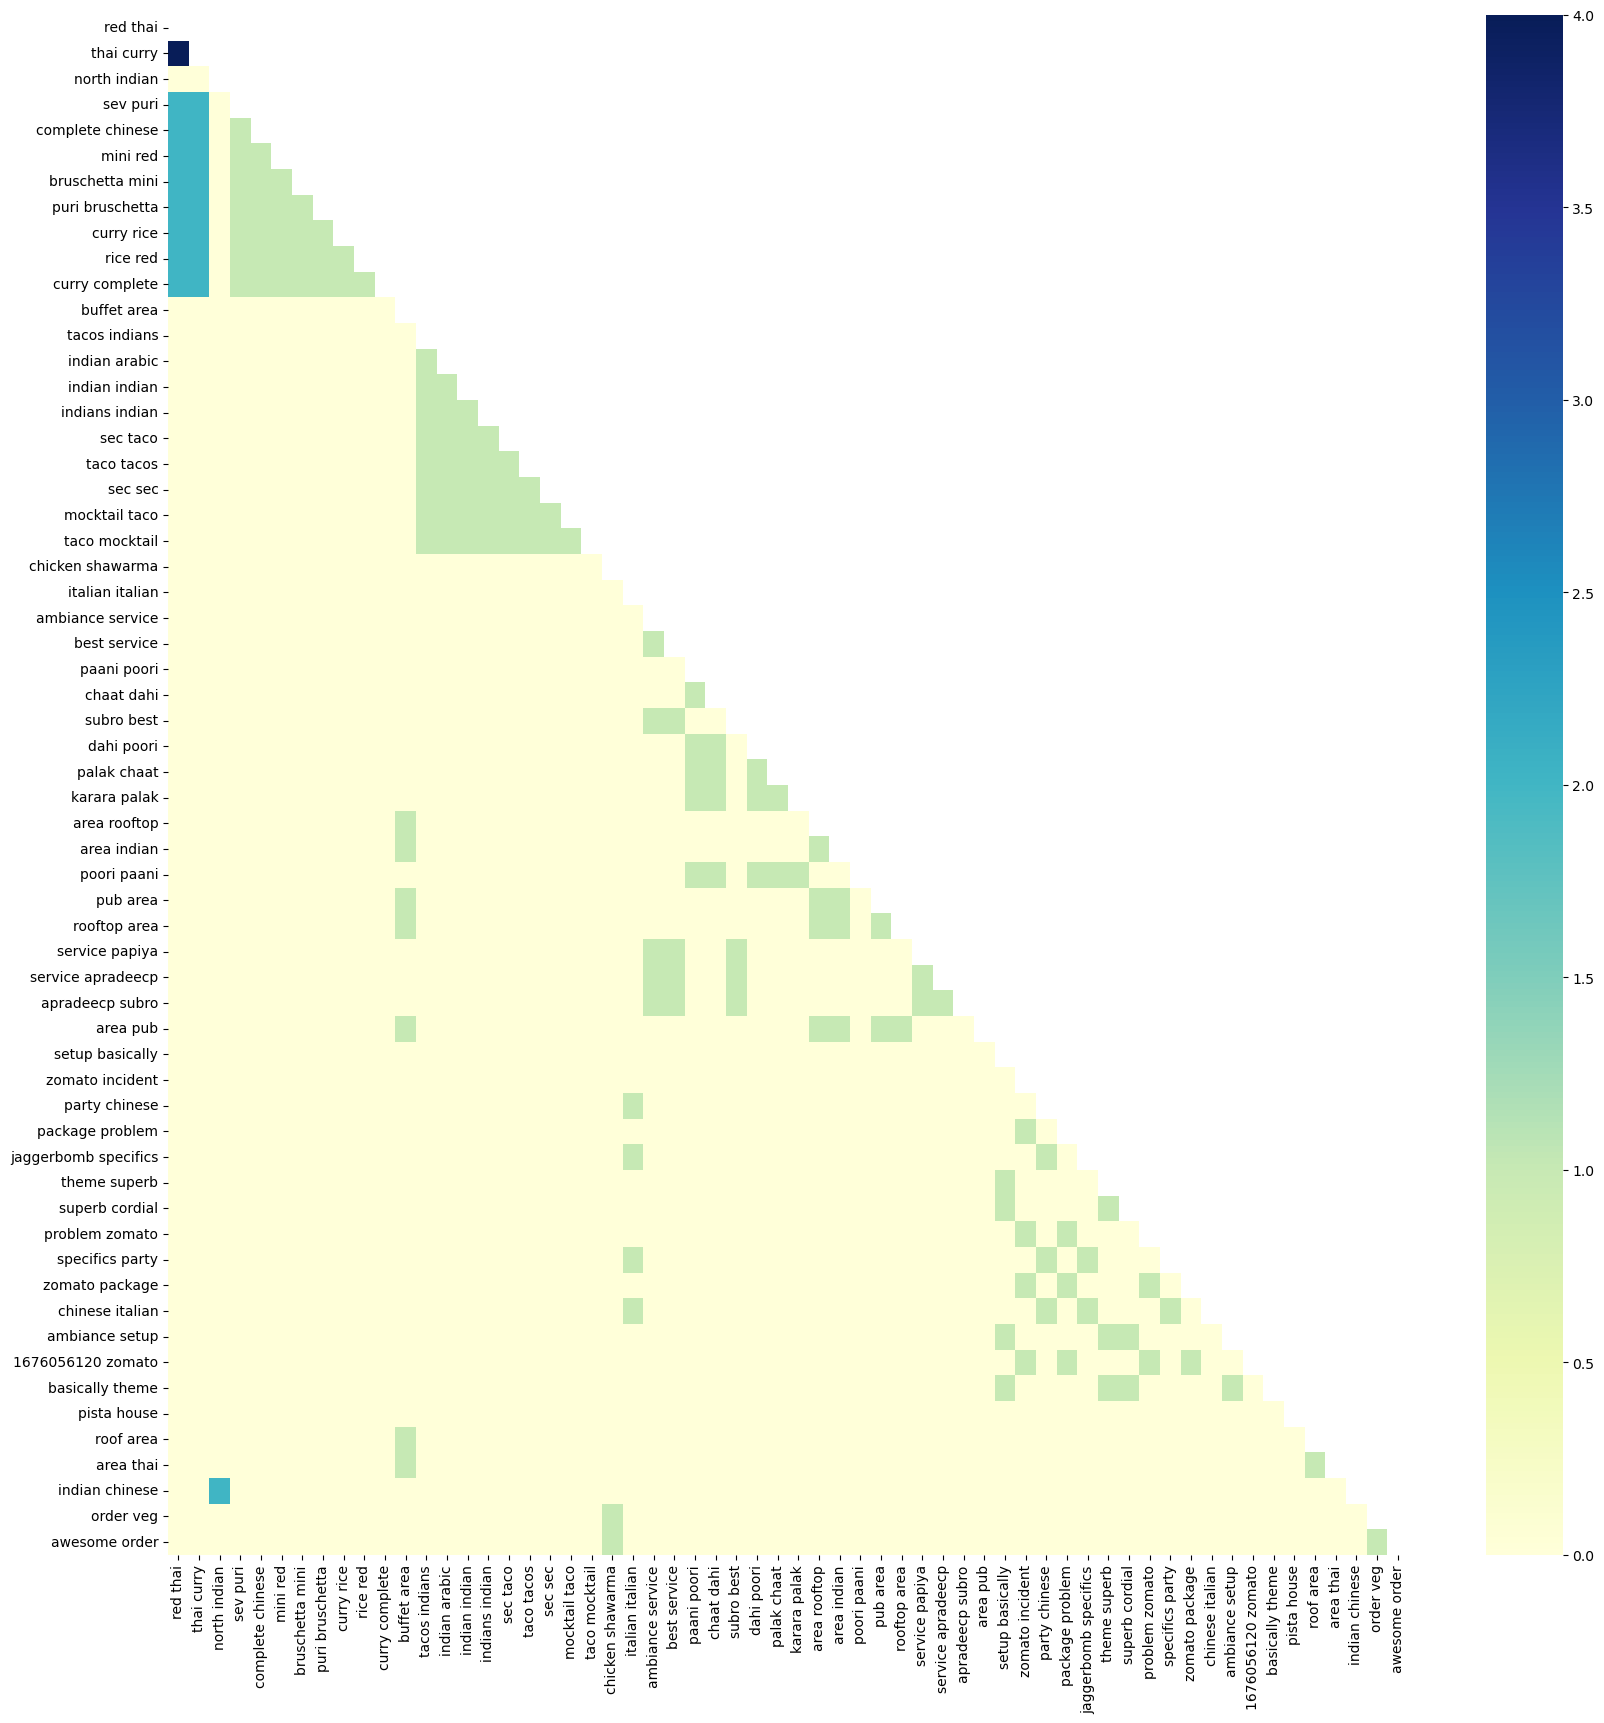

In [247]:
mask = np.triu(np.ones_like(co_matrix_df.iloc[:60, :60], dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(cooccurrence_matrix.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

In this one, there are a lot of combinations filled with zeros, indicating that these words do not appear together with other. When we applied named entity recognition a lot of words were discarted, consequently our co-occurrence matrix has values between 0 and 4.

#### Approach of removing the top 50 most common words

It was decided to try a different approach by identifying the 50 most common words in the top 10 cuisines with the most reviews. Since many of the most common words, as observed earlier, were not related to dishes, it was decided to create a co-occurrence matrix excluding these 50 words. To identify these top 50 words, the reviews and restaurant datasets were combined.

In [250]:
reviews_with_cuisine = pd.merge(reviews, restaurants[['Name', 'Cuisines']], left_on='Restaurant', right_on='Name', how='left')
reviews_with_cuisine.drop('Name', axis=1, inplace=True)

In [251]:
reviews_with_cuisine = reviews_with_cuisine.explode("Cuisines")

In [252]:
cuisine_review_counts = reviews_with_cuisine['Cuisines'].value_counts()
top_cuisines = cuisine_review_counts.head(10)

top_cuisines_list = top_cuisines.index.tolist()
reviews_top_cuisines = reviews_with_cuisine[reviews_with_cuisine['Cuisines'].isin(top_cuisines_list)]

print("Cuisines with the most reviews:")
print(top_cuisines)

Cuisines with the most reviews:
Cuisines
North Indian    5904
Chinese         4023
Continental     2081
Biryani         1454
Italian         1398
Asian           1385
Desserts        1274
Fast Food       1248
South Indian     882
Kebab            599
Name: count, dtype: int64


In [253]:
cuisine_review_counts = reviews_with_cuisine['Cuisines'].value_counts()
top_cuisines = cuisine_review_counts.head(8)

# Filter the dataset to include only rows with these top cuisines
top_cuisines_list = top_cuisines.index.tolist()
reviews_top_cuisines = reviews_with_cuisine[reviews_with_cuisine['Cuisines'].isin(top_cuisines_list)]

all_reviews = " ".join(reviews_top_cuisines['rev_proc'].dropna())  # Combine all reviews into one string

vectorizer = CountVectorizer(stop_words='english', max_features=50)  # tokenizing
word_counts = vectorizer.fit_transform([all_reviews])

# Get top 50 words and their frequencies
top_50_words = [word for word, _ in sorted(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)), key=lambda x: x[1], reverse=True)[:50]]
top_50_words

['service',
 'chicken',
 'order',
 'taste',
 'ambience',
 'great',
 'time',
 'try',
 'visit',
 'like',
 'really',
 'biryani',
 'nice',
 'restaurant',
 'staff',
 'serve',
 'best',
 'experience',
 'veg',
 'bad',
 'make',
 'love',
 'starter',
 'dish',
 'buffet',
 'friend',
 'amaze',
 'come',
 'awesome',
 'quality',
 'price',
 'overall',
 'drink',
 'rice',
 'item',
 'paneer',
 'recommend',
 'tasty',
 'menu',
 'lunch',
 'ambiance',
 'say',
 'main',
 'quantity',
 'music',
 'course',
 'delicious',
 'pizza',
 'fish',
 'table']

In [254]:
def remove_top_50_words(review):
    review_words = review.split()  # Split the review into words
    filtered_review = [word for word in review_words if word not in top_50_words]  # Remove top 50 words
    return " ".join(filtered_review)  # Return the filtered review as a string

In [255]:
reviews['rev_proc_filtered'] = reviews['rev_proc'].apply(remove_top_50_words)

print(reviews[['rev_proc', 'rev_proc_filtered']].head())

                                            rev_proc  \
0  ambience quite saturday lunch cost effective s...   
1  ambience pleasant even service prompt experien...   
2  must try great great ambience thnx service pra...   
3  soumen da arun great guy behavior sincerety co...   
4  order kodi drumstick basket mutton biryani tha...   

                                   rev_proc_filtered  
0  quite saturday cost effective sate brunch one ...  
1            pleasant even prompt soumen das - kudos  
2  must thnx pradeep subroto personal recommendat...  
3        soumen da arun guy behavior sincerety would  
4  kodi drumstick basket mutton thanks pradeep we...  


In [256]:
cooccurrence_matrix = generate_cooccurrence_matrix_ngrams(reviews, text_column='rev_proc_filtered', chunk_size=1000, ngram_range=(2, 2), top_n=100)

C:\Users\adria\anaconda3\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



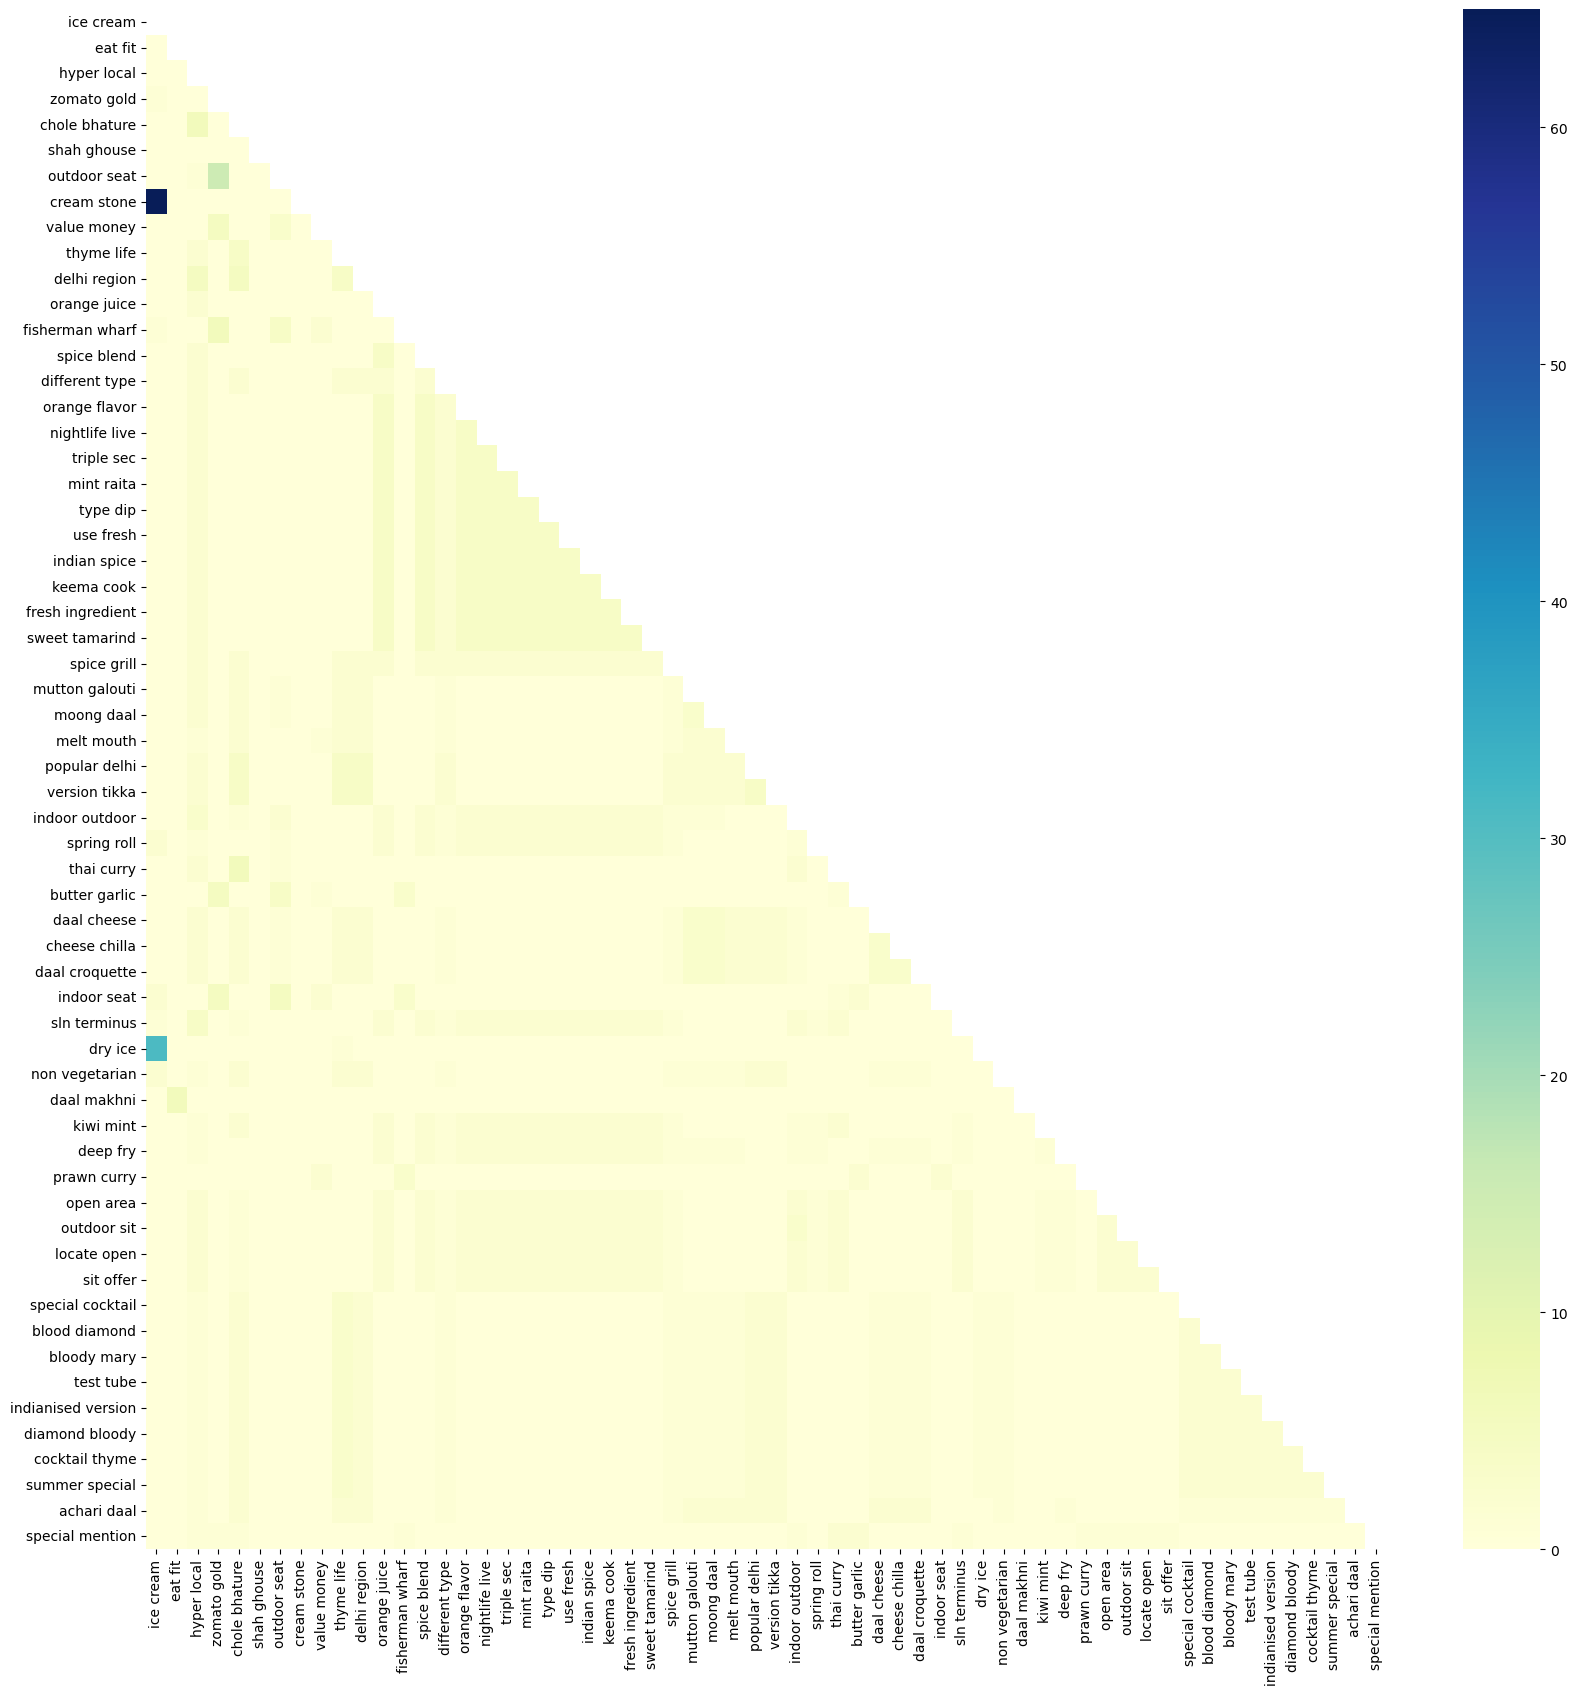

In [257]:
mask = np.triu(np.ones_like(co_matrix_df.iloc[:60, :60], dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(cooccurrence_matrix.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

#### Using a Pre trained model

Another approach involved using a pre-trained model from the Transformers package to identify food-related content in the reviews. As a result, a co-occurrence matrix was created using only the reviews that contained food-related content.

In [260]:
# Define batch size and initialize list for predictions
batch_size = 16
food_related_labels = []

# Load the pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("tanvircr7/learn_hf_food_not_food_text_classifier-distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("tanvircr7/learn_hf_food_not_food_text_classifier-distilbert-base-uncased")

# Get the label mapping
label_map = model.config.id2label  # This should map the index to 'food' or 'not food'

# Process the reviews in batches
for i in range(0, len(reviews), batch_size):
    batch = reviews['rev_proc'].iloc[i:i+batch_size].tolist()  # Get the batch of reviews
    inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Pass the tokenized inputs to the model and get the outputs
    with torch.no_grad():  # Inference mode (no gradients needed)
        outputs = model(**inputs)
    
    logits = outputs.logits # Get logits (raw prediction scores)
    predicted_class_ids = torch.argmax(logits, dim=-1).tolist() # Get predicted class IDs 

    # Map the predicted class IDs to the corresponding labels using label_map
    predicted_class_labels = [label_map[id] for id in predicted_class_ids]  

    food_related_labels.extend(predicted_class_labels)

reviews['food_related'] = food_related_labels
print(reviews[['rev_proc', 'food_related']])


                                               rev_proc food_related
0     ambience quite saturday lunch cost effective s...     not_food
1     ambience pleasant even service prompt experien...     not_food
2     must try great great ambience thnx service pra...         food
3     soumen da arun great guy behavior sincerety co...     not_food
4     order kodi drumstick basket mutton biryani tha...         food
...                                                 ...          ...
9995  madhumathi mahajan well start nice courteous s...         food
9996  never disappoint u courteous staff serene ambi...         food
9997  bad rat mainly chicken bone find veg acceptabl...         food
9998  personally love prefer chinese couple time hus...     not_food
9999  checked try delicious chinese see non-veg lunc...         food

[9804 rows x 2 columns]


In [261]:
food_related_sentences = reviews[reviews['food_related'] == 'food']
food_related_df = food_related_sentences[['rev_proc', 'food_related']]

In [262]:
cooccurrence_matrix1 = generate_cooccurrence_matrix_ngrams(food_related_df, text_column='rev_proc', chunk_size=1000, ngram_range=(2, 2), top_n=100)

C:\Users\adria\anaconda3\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



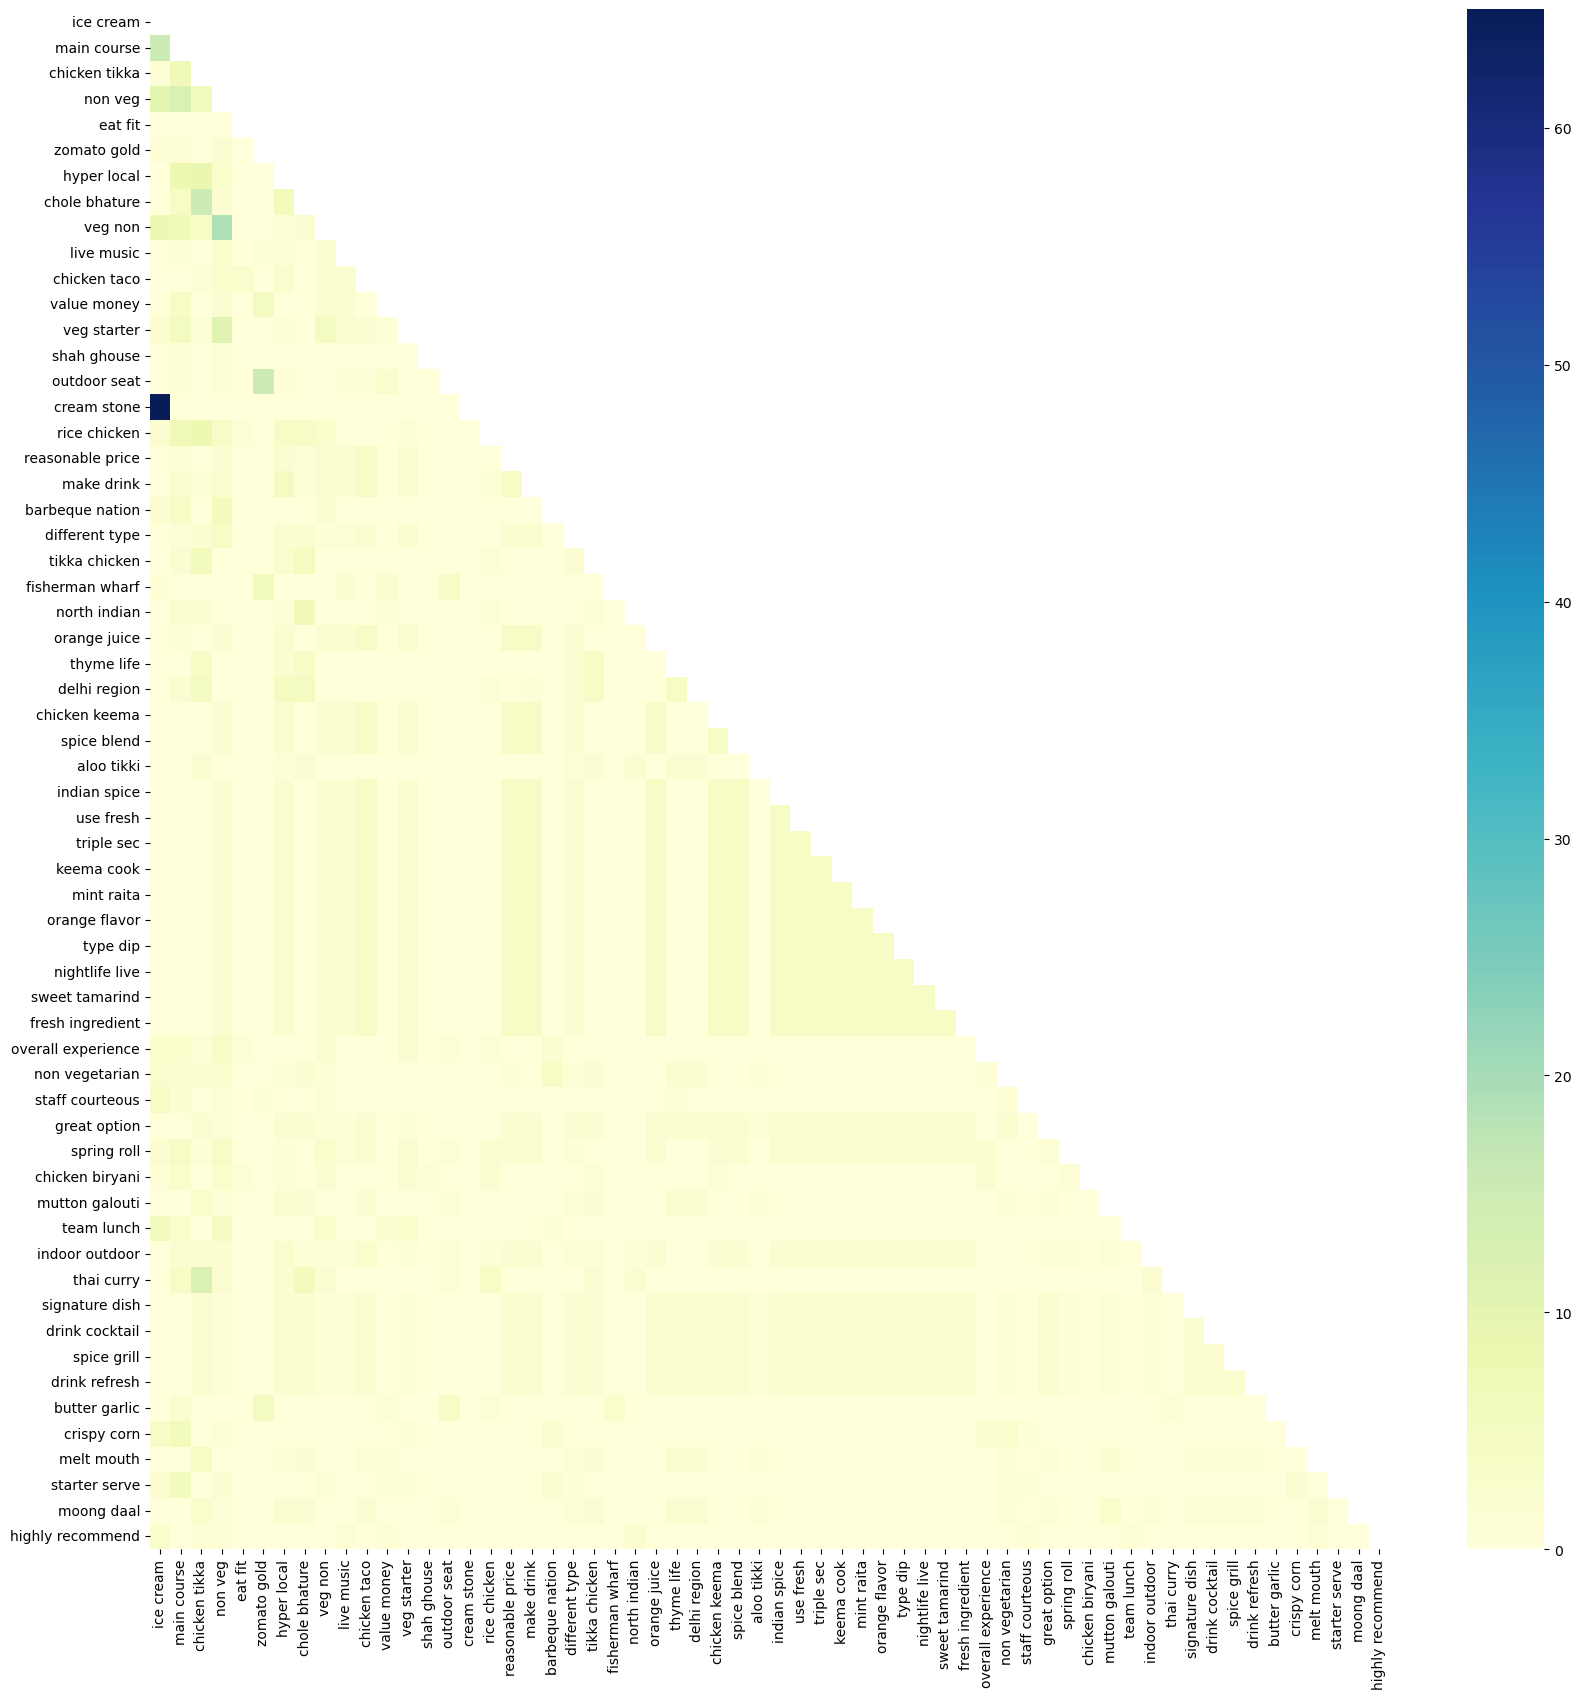

In [263]:
mask = np.triu(np.ones_like(cooccurrence_matrix1.iloc[:60, :60], dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(cooccurrence_matrix1.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

In this final approach we could see improvements as the co-occurrence matrix is filled with more values closer to ten. This is our best co-occurence matrix among all the approaches tested.

<font color='#BFD72F' size=5>2.3 Network Graph </font> <a class="anchor" id="P21"></a>
[Back to TOC](#toc)

In [266]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_words):
    
    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_words, :n_highest_words]
    graph = nx.Graph()

    # Add nodes for words and set their sizes based on frequency
    for word in filtered_df.columns:
        graph.add_node(word, size=filtered_df[word].sum())

    # Add weighted edges to the graph based on co-occurrence frequency
    for word1 in filtered_df.columns:
        for word2 in filtered_df.columns:
            if word1 != word2:
                graph.add_edge(word1, word2, weight=filtered_df.loc[word1, word2])

    figure = plt.figure(figsize=(14, 12))

    # Generate positions for the nodes
    pos = nx.spring_layout(graph, k=0.5)

    # Calculate edge widths based on co-occurrence frequency
    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]

    # Get node sizes based on the frequency of words
    node_sizes = [data['size'] * 2 for _, data in graph.nodes(data=True)]

    # Create the network graph
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights)
    nx.draw_networkx_labels(graph, pos, font_weight='bold', font_size=12)

    plt.show() 

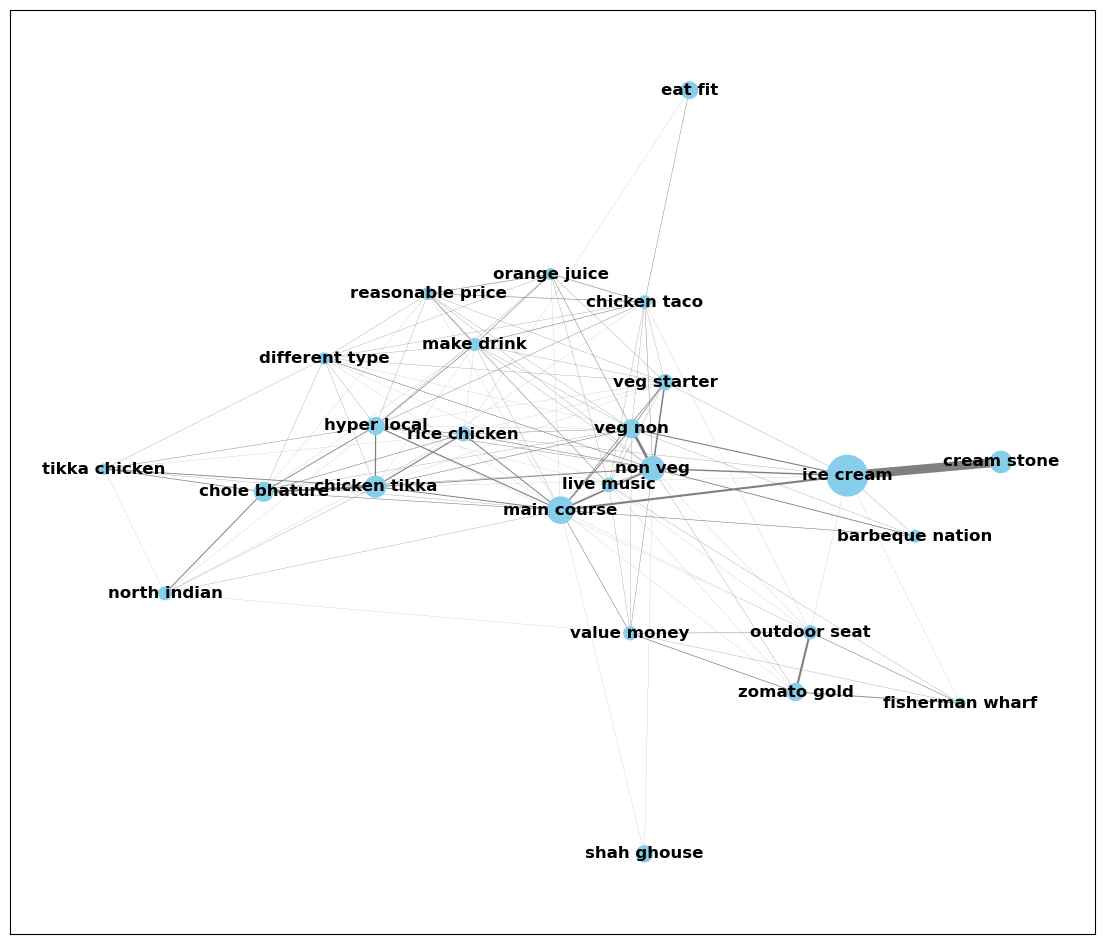

In [268]:
cooccurrence_network_generator(cooccurrence_matrix1, 25)

With this plot a strong connection can be seen between "ice cream" and "cream stone". 

<font color='#BFD72F' size=5>2.3 Clustering </font> <a class="anchor" id="P21"></a>
[Back to TOC](#toc)

For the clustering process, two vectorization methods were applied: Bag of Words (BoW) and TF-IDF. K-Means was selected as the clustering algorithm, and the clustering performance was evaluated using three metrics: Inertia, Silhouette Score, and Calinski-Harabasz Index.

In [10]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
reviews_bow_td_matrix = bow_vectorizer.fit_transform(reviews['rev_proc']).toarray()
reviews["bow_vector"] = reviews_bow_td_matrix.tolist()

In [272]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
reviews_tfidf_td_matrix = tfidf_vectorizer.fit_transform(reviews["rev_proc"]).toarray()
reviews["tfidf_vector"] = reviews_tfidf_td_matrix.tolist()

In [11]:
reviews_bow_td_matrix = np.array([[component for component in doc] for doc in reviews["bow_vector"]])

In [274]:
reviews_tfidf_td_matrix = np.array([[component for component in doc] for doc in reviews["tfidf_vector"]])

Here we applied K-Means for both BoW and TF-IDF

In [12]:
kmeans_bow = KMeans(n_clusters=11, random_state=39).fit(reviews_bow_td_matrix)
reviews["kmeans_bow_clusters"] = kmeans_bow.labels_.tolist()

In [276]:
kmeans_tfidf = KMeans(n_clusters=11, random_state=39).fit(reviews_tfidf_td_matrix)
reviews["kmeans_tfidf_clusters"] = kmeans_tfidf.labels_.tolist()

To understand the performance of the K-Means for each vectorizer we used three different metrics.

In [277]:
model_list = [("kmeans BoW k=11", kmeans_bow, reviews_bow_td_matrix), ("kmeans tfidf k=11", kmeans_tfidf, reviews_tfidf_td_matrix)]

def unsupervised_score_calculator(model_list):
    for tuple in model_list:
        #Inertia
        print("Inertia of {}: {}".format(tuple[0],tuple[1].inertia_))
        #Silhouette Score
        print("Silhouette score of {}: {}".format(tuple[0],silhouette_score(tuple[2],tuple[1].labels_)))
        #calinski-harabasz
        print("Calinski-Harabasz score of {}: {}".format(tuple[0],calinski_harabasz_score(tuple[2],tuple[1].labels_)))
        print("\n")

In [278]:
unsupervised_score_calculator(model_list)

Inertia of kmeans BoW k=11: 324895.3951334389
Silhouette score of kmeans BoW k=11: 0.07002927679668125
Calinski-Harabasz score of kmeans BoW k=11: 119.48955132737332


Inertia of kmeans tfidf k=11: 8931.08243541485
Silhouette score of kmeans tfidf k=11: 0.0028762500781132194
Calinski-Harabasz score of kmeans tfidf k=11: 33.59289493658272




With this scores it can be assessed that BoW produces more compact clusters as it has a lower inertia, the clustering quality is still poor, as shown by the low Silhouette and Calinski-Harabasz scores. The TF-IDF shows even poorer performance across all metrics.

In [280]:
def inertia_plotter(tf_matrix, max_k = 10, verbose=False):
    x_k_nr = []
    y_inertia = []
    for k in tqdm(range(2,max_k+1)):
        x_k_nr.append(k)
        kmeans = KMeans(n_clusters=k,random_state=0).fit(tf_matrix)
        y_inertia.append(kmeans.inertia_)
        if verbose==True:
            print("For k = {}, inertia = {}".format(k,round(kmeans.inertia_,3)))
    fig = px.line(x=x_k_nr, y=y_inertia, markers=True)
    fig.show()

In [281]:
inertia_plotter(reviews_bow_td_matrix,30)

100%|██████████| 29/29 [02:49<00:00,  5.84s/it]


In [282]:
inertia_plotter(reviews_tfidf_td_matrix,30)

100%|██████████| 29/29 [04:26<00:00,  9.20s/it]


It was decided to use the elbow finder to know the optimal number of k to use on K-Means

In [283]:
def elbow_finder(tf_matrix, max_k=10, verbose=True):
    
    y_inertia = []
    for k in tqdm(range(1,max_k+1)):
        kmeans = KMeans(n_clusters=k,random_state=0).fit(tf_matrix)
        if verbose==True:
            print("For k = {}, inertia = {}".format(k,round(kmeans.inertia_,3)))
        y_inertia.append(kmeans.inertia_)

    x = np.array([1, max_k])
    y = np.array([y_inertia[0], y_inertia[-1]])
    coefficients = np.polyfit(x, y, 1)
    line = np.poly1d(coefficients)

    a = coefficients[0]
    c = coefficients[1]

    elbow_point = max(range(1, max_k+1), key=lambda i: abs(y_inertia[i-1] - line(i)) / np.sqrt(a**2 + 1))
    print(f'Optimal value of k according to the elbow method: {elbow_point}')
    
    return elbow_point

In [284]:
elbow_finder(reviews_bow_td_matrix,40)

  2%|▎         | 1/40 [00:02<01:34,  2.43s/it]

For k = 1, inertia = 364537.594


  5%|▌         | 2/40 [00:05<01:40,  2.64s/it]

For k = 2, inertia = 348630.215


  8%|▊         | 3/40 [00:07<01:39,  2.68s/it]

For k = 3, inertia = 340816.127


 10%|█         | 4/40 [00:10<01:39,  2.75s/it]

For k = 4, inertia = 339414.881


 12%|█▎        | 5/40 [00:14<01:48,  3.11s/it]

For k = 5, inertia = 339150.556


 15%|█▌        | 6/40 [00:17<01:43,  3.04s/it]

For k = 6, inertia = 337937.045


 18%|█▊        | 7/40 [00:21<01:48,  3.27s/it]

For k = 7, inertia = 332514.114


 20%|██        | 8/40 [00:25<01:58,  3.70s/it]

For k = 8, inertia = 330656.861


 22%|██▎       | 9/40 [00:31<02:12,  4.28s/it]

For k = 9, inertia = 329033.933


 25%|██▌       | 10/40 [00:37<02:21,  4.72s/it]

For k = 10, inertia = 328654.553


 28%|██▊       | 11/40 [00:43<02:27,  5.09s/it]

For k = 11, inertia = 327467.707


 30%|███       | 12/40 [00:47<02:20,  5.03s/it]

For k = 12, inertia = 325584.17


 32%|███▎      | 13/40 [00:53<02:23,  5.32s/it]

For k = 13, inertia = 323256.682


 35%|███▌      | 14/40 [01:00<02:26,  5.62s/it]

For k = 14, inertia = 322961.561


 38%|███▊      | 15/40 [01:05<02:21,  5.64s/it]

For k = 15, inertia = 321718.996


 40%|████      | 16/40 [01:11<02:13,  5.55s/it]

For k = 16, inertia = 321184.258


 42%|████▎     | 17/40 [01:18<02:19,  6.08s/it]

For k = 17, inertia = 320899.088


 45%|████▌     | 18/40 [01:24<02:13,  6.06s/it]

For k = 18, inertia = 319968.488


 48%|████▊     | 19/40 [01:30<02:09,  6.17s/it]

For k = 19, inertia = 319442.53


 50%|█████     | 20/40 [01:36<01:56,  5.84s/it]

For k = 20, inertia = 318505.663


 52%|█████▎    | 21/40 [01:47<02:22,  7.48s/it]

For k = 21, inertia = 320107.153


 55%|█████▌    | 22/40 [01:56<02:25,  8.11s/it]

For k = 22, inertia = 319579.268


 57%|█████▊    | 23/40 [02:06<02:23,  8.47s/it]

For k = 23, inertia = 319235.543


 60%|██████    | 24/40 [02:11<02:01,  7.59s/it]

For k = 24, inertia = 320544.251


 62%|██████▎   | 25/40 [02:18<01:50,  7.34s/it]

For k = 25, inertia = 319684.432


 65%|██████▌   | 26/40 [02:24<01:36,  6.90s/it]

For k = 26, inertia = 319062.767


 68%|██████▊   | 27/40 [02:30<01:25,  6.57s/it]

For k = 27, inertia = 318677.904


 70%|███████   | 28/40 [02:36<01:18,  6.51s/it]

For k = 28, inertia = 316418.152


 72%|███████▎  | 29/40 [02:42<01:08,  6.24s/it]

For k = 29, inertia = 315008.234


 75%|███████▌  | 30/40 [02:50<01:07,  6.76s/it]

For k = 30, inertia = 312851.91


 78%|███████▊  | 31/40 [03:00<01:09,  7.77s/it]

For k = 31, inertia = 312084.616


 80%|████████  | 32/40 [03:09<01:04,  8.12s/it]

For k = 32, inertia = 311394.405


 82%|████████▎ | 33/40 [03:24<01:12, 10.39s/it]

For k = 33, inertia = 309644.157


 85%|████████▌ | 34/40 [03:35<01:01, 10.31s/it]

For k = 34, inertia = 309471.802


 88%|████████▊ | 35/40 [03:47<00:55, 11.06s/it]

For k = 35, inertia = 307962.668


 90%|█████████ | 36/40 [04:05<00:51, 12.99s/it]

For k = 36, inertia = 307559.869


 92%|█████████▎| 37/40 [04:30<00:49, 16.57s/it]

For k = 37, inertia = 307172.251


 95%|█████████▌| 38/40 [04:38<00:28, 14.16s/it]

For k = 38, inertia = 307406.432


 98%|█████████▊| 39/40 [04:49<00:12, 12.97s/it]

For k = 39, inertia = 306906.235


100%|██████████| 40/40 [04:58<00:00,  7.47s/it]

For k = 40, inertia = 305255.235
Optimal value of k according to the elbow method: 9


9

In [285]:
elbow_finder(reviews_tfidf_td_matrix,40)

  2%|▎         | 1/40 [00:02<01:45,  2.69s/it]

For k = 1, inertia = 9237.445


  5%|▌         | 2/40 [00:07<02:23,  3.79s/it]

For k = 2, inertia = 9159.496


  8%|▊         | 3/40 [00:09<02:00,  3.26s/it]

For k = 3, inertia = 9235.528


 10%|█         | 4/40 [00:12<01:48,  3.02s/it]

For k = 4, inertia = 9234.549


 12%|█▎        | 5/40 [00:15<01:43,  2.95s/it]

For k = 5, inertia = 9233.549


 15%|█▌        | 6/40 [00:19<01:50,  3.25s/it]

For k = 6, inertia = 9151.665


 18%|█▊        | 7/40 [00:24<02:04,  3.77s/it]

For k = 7, inertia = 9099.621


 20%|██        | 8/40 [00:27<01:59,  3.73s/it]

For k = 8, inertia = 9096.744


 22%|██▎       | 9/40 [00:33<02:11,  4.25s/it]

For k = 9, inertia = 9095.799


 25%|██▌       | 10/40 [00:37<02:09,  4.33s/it]

For k = 10, inertia = 9086.263


 28%|██▊       | 11/40 [00:42<02:09,  4.47s/it]

For k = 11, inertia = 9084.614


 30%|███       | 12/40 [00:46<02:05,  4.48s/it]

For k = 12, inertia = 9083.622


 32%|███▎      | 13/40 [00:51<02:01,  4.51s/it]

For k = 13, inertia = 9078.599


 35%|███▌      | 14/40 [00:56<02:02,  4.72s/it]

For k = 14, inertia = 9065.545


 38%|███▊      | 15/40 [01:01<02:01,  4.87s/it]

For k = 15, inertia = 9063.923


 40%|████      | 16/40 [01:06<01:51,  4.66s/it]

For k = 16, inertia = 9031.404


 42%|████▎     | 17/40 [01:11<01:53,  4.93s/it]

For k = 17, inertia = 9030.411


 45%|████▌     | 18/40 [01:16<01:47,  4.88s/it]

For k = 18, inertia = 9029.44


 48%|████▊     | 19/40 [01:21<01:44,  4.99s/it]

For k = 19, inertia = 9008.109


 50%|█████     | 20/40 [01:30<02:05,  6.29s/it]

For k = 20, inertia = 8881.059


 52%|█████▎    | 21/40 [01:40<02:15,  7.14s/it]

For k = 21, inertia = 8898.047


 55%|█████▌    | 22/40 [01:59<03:12, 10.69s/it]

For k = 22, inertia = 8849.463


 57%|█████▊    | 23/40 [02:16<03:35, 12.66s/it]

For k = 23, inertia = 8846.083


 60%|██████    | 24/40 [02:33<03:44, 14.03s/it]

For k = 24, inertia = 8839.106


 62%|██████▎   | 25/40 [02:53<03:56, 15.74s/it]

For k = 25, inertia = 8838.13


 65%|██████▌   | 26/40 [03:13<03:57, 16.98s/it]

For k = 26, inertia = 8833.583


 68%|██████▊   | 27/40 [03:32<03:48, 17.57s/it]

For k = 27, inertia = 8832.593


 70%|███████   | 28/40 [03:49<03:31, 17.61s/it]

For k = 28, inertia = 8818.361


 72%|███████▎  | 29/40 [04:09<03:20, 18.26s/it]

For k = 29, inertia = 8809.414


 75%|███████▌  | 30/40 [04:31<03:14, 19.41s/it]

For k = 30, inertia = 8798.129


 78%|███████▊  | 31/40 [04:52<02:57, 19.75s/it]

For k = 31, inertia = 8797.151


 80%|████████  | 32/40 [05:11<02:36, 19.54s/it]

For k = 32, inertia = 8788.654


 82%|████████▎ | 33/40 [05:33<02:23, 20.46s/it]

For k = 33, inertia = 8787.671


 85%|████████▌ | 34/40 [05:54<02:03, 20.66s/it]

For k = 34, inertia = 8773.277


 88%|████████▊ | 35/40 [06:17<01:45, 21.14s/it]

For k = 35, inertia = 8772.275


 90%|█████████ | 36/40 [06:37<01:23, 20.81s/it]

For k = 36, inertia = 8771.301


 92%|█████████▎| 37/40 [06:59<01:03, 21.20s/it]

For k = 37, inertia = 8761.225


 95%|█████████▌| 38/40 [07:21<00:43, 21.54s/it]

For k = 38, inertia = 8760.254


 98%|█████████▊| 39/40 [07:43<00:21, 21.68s/it]

For k = 39, inertia = 8759.299


100%|██████████| 40/40 [07:54<00:00, 11.86s/it]

For k = 40, inertia = 8749.083
Optimal value of k according to the elbow method: 22


22

With the elbow method the suggested number of k when using BoW is 9 and little improvements can be seen as the inertia reduced  when comparing with k=11

As BoW has overall better performance than Tf-IDF it was decided to plot a 3d plot of the clusters

In [6]:
def cluster_namer_bow(dataset, label_column_name, text_column_name, nr_words=5):

    labels = list(set(dataset[label_column_name]))
    
    # Create a corpus for each label
    corpus = []
    for label in labels:
        label_text = " ".join(dataset[text_column_name][dataset[label_column_name] == label])
        corpus.append(label_text)
        
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(corpus)
    feature_names = bow_vectorizer.get_feature_names_out()
    
    # Generate cluster names
    label_name_list = []
    for idx in range(len(labels)):
        # Extract word counts for the current cluster
        word_counts = bow_matrix[idx].toarray().flatten()
        
        # Pair words with their counts and sort by frequency
        word_freqs = sorted(zip(feature_names, word_counts), key=lambda x: x[1], reverse=True)
        
        # Select top words and construct the label name
        top_words = [word for word, count in word_freqs[:nr_words]]
        label_name = "_".join(top_words)
        label_name_list.append(label_name)
    
    # Map labels to their generated names
    label_name_dict = dict(zip(labels, label_name_list))
    dataset[label_column_name] = dataset[label_column_name].map(label_name_dict)
    
    return dataset

In [13]:
reviews = cluster_namer_bow(reviews, "kmeans_bow_clusters", "rev_proc")

In [18]:
def plotter_3d_cluster(dataset_, vector_column_name, cluster_label_name,text_column_name):
    
    dataset = dataset_.copy()
    dataset = cluster_namer_bow(dataset, cluster_label_name, text_column_name)

    # Applying SVD as a dimensionality reduction technique
    svd_n3 = TruncatedSVD(n_components=3) # reduce to 3 dimensions
    td_matrix = np.array([[component for component in doc] for doc in dataset[vector_column_name]])
    svd_result = svd_n3.fit_transform(td_matrix)

    for component in range(3):
        col_name = "svd_d3_x{}".format(component)
        dataset[col_name] = svd_result[:,component].tolist()

    fig = px.scatter_3d(dataset,
                        x='svd_d3_x0',
                        y='svd_d3_x1',
                        z='svd_d3_x2',
                        color=cluster_label_name,
                        title=vector_column_name+"__"+cluster_label_name,
                        opacity=0.9,
                        hover_name = "rev_proc",
                        color_discrete_sequence=px.colors.qualitative.Alphabet)
    fig.update_traces(marker=dict(size=4))
    fig.update_layout(height = 1000 , width = 1000)

    fig.show()

In [19]:
plotter_3d_cluster(reviews,"bow_vector","kmeans_bow_clusters","rev_proc")

Although the clusters appear well-defined visually, it was challenging to determine the specific cuisine type represented by each cluster.